# AI Community @ Семинар № 9
## Основы компьютерного зрения. Отделение фона и отслеживание объектов на видеопотоке (алгоритмы Optical Flow, Meanshift/Camshift)

## Optical Flow

Алгоритм Optical Flow - один из способов отслеживать перемещение объекта на видеопотоке.

Optical Flow основывается на двух важных предположениях:
1. Интенсивность пикселей движущегося объекта не изменяется.
1. Соседние пиксели имеют похожие движения.

[Optical Flow в OpenCV](https://docs.opencv.org/3.2.0/d7/d8b/tutorial_py_lucas_kanade.html)

Следуя выводам из [Optical flow](https://en.wikipedia.org/wiki/Optical_flow) необходимо решить следующее уравнение:
$$\frac{\partial I}{\partial x} V_x + \frac{\partial I}{\partial y} V_y + \frac{\partial I}{\partial t} = 0$$

$\frac{\partial I}{\partial x}$, $\frac{\partial I}{\partial y}$ и $\frac{\partial I}{\partial t}$ мы можем посчитать по изображению. Остаются две переменные $V_x$ и $V_y$. Одно уравнение относительно двух переменных не решить однозначно. На анимации ниже показано, почему это так. Проблема имеет название ["Проблема апертуры"](https://en.wikipedia.org/wiki/Motion_perception#The_aperture_problem). Для решения этого уравнения существуют разные подходы, среди которых:
1. [Lucas–Kanade method](https://en.wikipedia.org/wiki/Lucas%E2%80%93Kanade_method)
1. [Horn–Schunck method](https://en.wikipedia.org/wiki/Horn%E2%80%93Schunck_method)
1. [Farneback Dense Optical Flow](http://www.diva-portal.org/smash/get/diva2:273847/FULLTEXT01.pdf)

In [1]:
from IPython.display import HTML
HTML('<center><img src="images/aperture_problem_animated.gif" width=500></center>')

### Алгоритм Лукаса — Канаде

#### Теория

Алгоритм Лукаса-Канаде основан на втором предположении Optical Flow (естесственно, не без первого в т.ч.).  
Рассматривается окно вокруг целевого пикселя (обычно размером 3x3), в котором вектор скорости движения пикселей предполагается одинаковым. Из этого получается система нескольких уравнений, указанных выше. Это переопределенная система (число уравнений больше числа неизвестных), поэтому решить ее предлагается с помощью метода наименьших квадратов. Следуя формулам из [Алгоритм Лукаса — Канаде](https://ru.wikipedia.org/wiki/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%9B%D1%83%D0%BA%D0%B0%D1%81%D0%B0_%E2%80%94_%D0%9A%D0%B0%D0%BD%D0%B0%D0%B4%D0%B5) получаем следующее решение системы уравнений:

$$
\begin{bmatrix}
    V_x \\
    V_y
\end{bmatrix}
=
\begin{bmatrix}
    \sum_i{I_x(q_i)^2} & \sum_i{I_x(q_i)I_y(q_i)} \\
    \sum_i{I_x(q_i)I_y(q_i)} & \sum_i{I_y(q_i)^2}
\end{bmatrix}^{-1}
\begin{bmatrix}
    - \sum_i{I_x(q_i)I_t(q_i)} \\
    - \sum_i{I_y(q_i)I_t(q_i)}
\end{bmatrix}
$$

#### Практика

В [туториале OpenCV](https://docs.opencv.org/3.2.0/d7/d8b/tutorial_py_lucas_kanade.html) разобрано применение метода Лукаса-Канаде для отслеживания конкретных признаков, найденных на первом кадре видео (выполнен поиск хороших признаков таких, как углов).  
Но этот подход не работает, если с течением видео исходные признаки пропадают, что чаще всего и бывает. Поэтому рассмотрим реализацию [расширенного примера из репозитория OpenCV](https://github.com/opencv/opencv/blob/master/samples/python/lk_track.py).

In [2]:
import numpy as np
import cv2
import skvideo.io
from time import clock

lk_params = dict( winSize  = (15, 15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

feature_params = dict( maxCorners = 500,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

class App:
    def __init__(self, video_src):
        self.track_len = 50
        self.detect_interval = 5
        self.tracks = []
        vreader = skvideo.io.FFmpegReader(video_src)
        self.videogen = vreader.nextFrame()
        self.frame_idx = 0

    def run(self):
        for frame in self.videogen:
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
            vis = frame.copy()

            if len(self.tracks) > 0:
                img0, img1 = self.prev_gray, frame_gray
                
                p0 = np.float32([tr[-1] for tr in self.tracks]).reshape(-1, 1, 2)
                p1, _st, _err = cv2.calcOpticalFlowPyrLK(img0, img1, p0, None, **lk_params)
                p0r, _st, _err = cv2.calcOpticalFlowPyrLK(img1, img0, p1, None, **lk_params)
                
                d = abs(p0-p0r).reshape(-1, 2).max(-1)
                good = d < 1
                new_tracks = []
                
                for tr, (x, y), good_flag in zip(self.tracks, p1.reshape(-1, 2), good):
                    if not good_flag:
                        continue
                    
                    tr.append((x, y))
                    if len(tr) > self.track_len:
                        del tr[0]
                    
                    new_tracks.append(tr)
                    cv2.circle(vis, (x, y), 2, (0, 255, 0), -1)
                
                self.tracks = new_tracks
                cv2.polylines(vis, [np.int32(tr) for tr in self.tracks], False, (0, 255, 0))

            if self.frame_idx % self.detect_interval == 0:
                mask = np.zeros_like(frame_gray)
                mask[:] = 255
                
                for x, y in [np.int32(tr[-1]) for tr in self.tracks]:
                    cv2.circle(mask, (x, y), 5, 0, -1)
                p = cv2.goodFeaturesToTrack(frame_gray, mask = mask, **feature_params)
                
                if p is not None:
                    for x, y in np.float32(p).reshape(-1, 2):
                        self.tracks.append([(x, y)])


            self.frame_idx += 1
            self.prev_gray = frame_gray
            cv2.imshow('lk_track', cv2.resize(vis[..., ::-1], (1280, 720)))

            ch = cv2.waitKey(1)
            if ch == 27:
                break
        
        self.videogen.close()

/home/vladvin/anaconda3/lib/python3.6/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)


In [3]:
App('images/video_stop_ya.mp4').run()
cv2.destroyAllWindows()

![Lucas–Kanade Optical Flow](images/lk_opt_flow.png)

### Farneback Dense Optical Flow

#### [Теория](http://www.diva-portal.org/smash/get/diva2:273847/FULLTEXT01.pdf)

#### Практика

In [4]:
import cv2
import numpy as np

vreader = skvideo.io.FFmpegReader('images/video_stop_ya.mp4')
videogen = vreader.nextFrame()

prvs_frame = None

for frame in videogen:
    next_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    
    if prvs_frame is None:
        prvs_frame = next_frame
        hsv = np.zeros_like(frame)
        hsv[...,1] = 255
        continue
    
    flow = cv2.calcOpticalFlowFarneback(prvs_frame, next_frame, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
    
    fg = cv2.bitwise_and(frame, frame, mask=(hsv[..., 2] > 50).astype('uint8') * 255)
    vis = np.vstack([
        np.hstack([frame[..., ::-1], bgr]),
        np.hstack([np.zeros_like(fg), fg]),
    ])
    cv2.imshow('Dense Optical Flow', vis)
    
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
    
    prvs_frame = next_frame

videogen.close()
cv2.destroyAllWindows()

<img src="images/dense_opt_flow1.png" style="float: left; width: 40%">
<img src="images/dense_opt_flow2.png" style="float: right; width: 40%">

<img src="images/dense_opt_flow3.png">

## Meanshift

Вспомогательные ссылки:
1. [Back projection OpenCV](https://docs.opencv.org/2.4/doc/tutorials/imgproc/histograms/back_projection/back_projection.html)
1. [Meanshift OpenCV](https://docs.opencv.org/trunk/db/df8/tutorial_py_meanshift.html)

In [5]:
import matplotlib.pyplot as plt
from skimage.io import *

%matplotlib inline

In [6]:
vreader = skvideo.io.FFmpegReader('images/video_stop_ya.mp4')
videogen = vreader.nextFrame()
frames = [frame for frame in videogen]

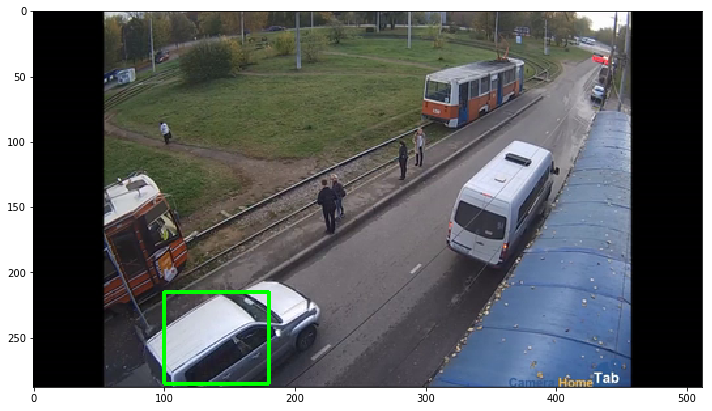

In [7]:
plt.figure(figsize=(10, 10))
img = frames[665].copy()
init_window = (100, 215, 80, 70)
cv2.rectangle(img, (init_window[0], init_window[1]),
              (init_window[0] + init_window[2], init_window[1] + init_window[3]),
              (0, 255, 0), thickness=2)
imshow(img)

In [8]:
import numpy as np
import cv2
import time

start_frame_idx = 665
frame = frames[start_frame_idx].copy()

# setup initial location of window
x, y, w, h = (100, 215, 80, 70)
track_window = (x, y, w, h)

# set up the ROI for tracking
roi = frame[y:y+h, x:x+w]
hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_RGB2HSV)

mask = cv2.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))

roi_hist = cv2.calcHist([hsv_roi],[0],mask,[180],[0,180])
cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX)

# Setup the termination criteria, either 10 iteration or move by atleast 1 pt
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

for frame in frames[start_frame_idx + 1:]:
    img = frame.copy()
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    dst = cv2.calcBackProject([hsv], [0], roi_hist, [0,180], 1)
    
    # apply meanshift to get the new location
    ret, track_window = cv2.meanShift(dst, track_window, term_crit)
    
    # Draw it on image
    x,y,w,h = track_window
    cv2.rectangle(img, (x,y), (x+w,y+h), (0, 255, 0), 2)
    
    cv2.imshow('Meanshift Tracking', img[..., ::-1])
    k = cv2.waitKey(60) & 0xff
    if k == 27:
        break
        
    time.sleep(0.2)

cv2.destroyAllWindows()

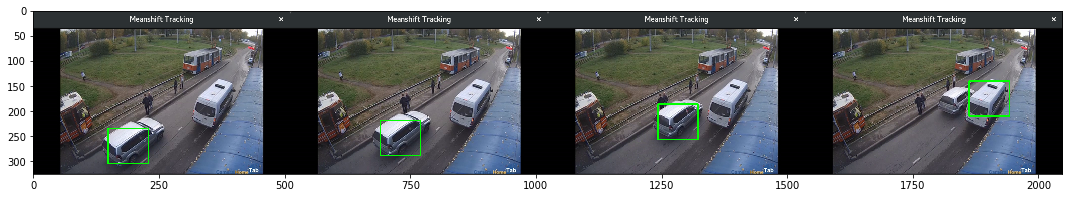

In [9]:
plt.figure(figsize=(15, 15))
imshow(np.hstack([
    imread('images/meanshift0.png'),
    imread('images/meanshift1.png'),
    imread('images/meanshift2.png'),
    imread('images/meanshift3.png')
]))

## Camshift

In [10]:
import numpy as np
import cv2
import time

start_frame_idx = 665
frame = frames[start_frame_idx].copy()

# setup initial location of window
x, y, w, h = (100, 215, 80, 70)
track_window = (x, y, w, h)

# set up the ROI for tracking
roi = frame[y:y+h, x:x+w]
hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_RGB2HSV)

mask = cv2.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))

roi_hist = cv2.calcHist([hsv_roi],[0],mask,[180],[0,180])
cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX)

# Setup the termination criteria, either 10 iteration or move by atleast 1 pt
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

for frame in frames[start_frame_idx + 1:]:
    img = frame.copy()
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    dst = cv2.calcBackProject([hsv], [0], roi_hist, [0,180], 1)
    
    # apply meanshift to get the new location
    ret, track_window = cv2.CamShift(dst, track_window, term_crit)
    
    # Draw it on image
    x,y,w,h = track_window
    cv2.rectangle(img, (x,y), (x+w,y+h), (0, 255, 0), 2)
    
    cv2.imshow('Meanshift Tracking', img[..., ::-1])
    k = cv2.waitKey(60) & 0xff
    if k == 27:
        break
        
    time.sleep(0.2)

cv2.destroyAllWindows()